In [3]:
import os
import sys
import pyro
import pandas as pd
import torch
import pickle

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch

from torch import Tensor
from tqdm.auto import trange
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive
from pyro.distributions import constraints
from pyro.infer.autoguide import AutoDiagonalNormal

print(os.getcwd())
datapath = os.getcwd()+"/folds/classification_data.csv"
# sys.path.append('../..')  # Adjust the path as needed

from src import SingleGP, MtlDeepGP, DeepGPNoBias, DeepGP, MtlDeepGP_classification, Deconfounder_z2x, Deconfounder_zx2y

/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/yuanfang/Desktop/zai/实习2024/MTL_DGP_YF


In [4]:
# torch.cpu.current_device()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
# cpu = torch.device('cpu') 
torch.manual_seed(42)

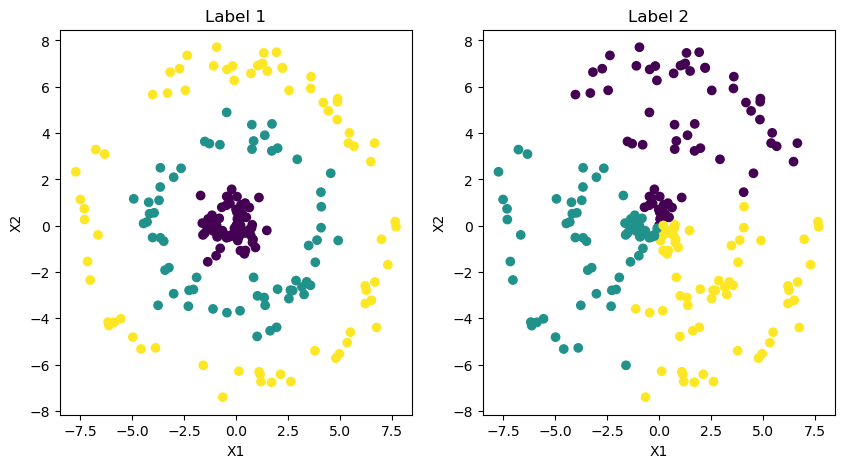

In [5]:
# Load data from CSV file
data = pd.read_csv(datapath)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].scatter(data['X1'], data['X2'], c=data['labels1'])
ax[1].scatter(data['X1'], data['X2'], c=data['labels2'])
ax[0].set_title('Label 1')
ax[1].set_title('Label 2')
ax[0].set_xlabel('X1')
ax[1].set_xlabel('X1')
ax[0].set_ylabel('X2')
ax[1].set_ylabel('X2')
plt.show()


In [6]:
# Load data from CSV
data = pd.read_csv(datapath)

# Separate the features (X) and outputs (Y1 and Y2)
X1 = data[['X1']].values  # input features
X2 = data[['X2']].values  # input features
Y10 = data[['labels1']].values  # output features
Y20 = data[['labels2']].values  # output features

num_classes1 = np.max(Y10) + 1  # 类别数
Y1 = np.eye(num_classes1)[Y10].squeeze()
num_classes2 = np.max(Y20) + 1  # 类别数
Y2 = np.eye(num_classes2)[Y20].squeeze()
print(Y1.shape, Y2.shape)
X = np.vstack((X1, X2)).T
Y = np.vstack((Y1, Y2)).T

from sklearn.model_selection import train_test_split

# Split into train and test for the inputs and both task outputs
X1_train, X1_test, X2_train, X2_test, Y1_train, Y1_test, Y2_train, Y2_test = train_test_split(X1, X2, Y1, Y2, test_size=0.2, random_state=42)

# Print the shapes of the train and test sets
print("Train X1:", X1_train.shape)
print("Test X1:", X1_test.shape)
print("Train X2:", X2_train.shape)
print("Test X2:", X2_test.shape)
print("Train Y1:", Y1_train.shape)
print("Test Y1:", Y1_test.shape)
print("Train Y2:", Y2_train.shape)
print("Test Y2:", Y2_test.shape)


(200, 3) (200, 3)
Train X1: (160, 1)
Test X1: (40, 1)
Train X2: (160, 1)
Test X2: (40, 1)
Train Y1: (160, 3)
Test Y1: (40, 3)
Train Y2: (160, 3)
Test Y2: (40, 3)


In [7]:
x_train = torch.tensor( np.hstack([X1_train, X2_train]), dtype=torch.float32)
y_train = torch.tensor( np.hstack([Y1_train, Y2_train]), dtype=torch.float32)
x_test = torch.tensor( np.hstack([X1_test, X2_test]) , dtype=torch.float32)
y_test = torch.tensor( np.hstack([Y1_test, Y2_test]), dtype=torch.float32)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([160, 2])
torch.Size([160, 6])
torch.Size([40, 2])
torch.Size([40, 6])


In [8]:
class JointModel(PyroModule):
    def __init__(self, x_dim=1, y_dim=1,  z_dim=1, J_list1=[10], J_list2=[10], N_train=10):
        super().__init__()
        # Shared hidden state across models
        hidden_state = pyro.sample("confounder", dist.Normal(0., 1.).expand([N_train, z_dim]).to_event(2))
        self.hidden_state = hidden_state
        dim_list1=[z_dim, x_dim] 
        dim_list2=[z_dim+x_dim, y_dim] 
        self.model1 = Deconfounder_z2x(dim_list=dim_list1, J_list=J_list1, shared_z=hidden_state).to('cpu')
        self.model2 = Deconfounder_zx2y(dim_list=dim_list2, J_list=J_list2, shared_z=hidden_state).to('cpu')
        self.x_dim = x_dim
        self.y_dim = y_dim

    def forward(self, x, y=None):
        mu1 = self.model1()
        mu2 = self.model2(x)

        scale1 = pyro.sample("sigma1", dist.Gamma(torch.tensor(0.5, device='cpu'), torch.tensor(1.0, device='cpu'))).expand(self.x_dim) 
        scale2 = pyro.sample("sigma2", dist.Gamma(torch.tensor(0.5, device='cpu'), torch.tensor(1.0, device='cpu'))).expand(self.y_dim) 
        # Sampling model
        with pyro.plate("data", x.shape[0]): 
            obs1 = pyro.sample("obs1", dist.MultivariateNormal(mu1.cpu(), torch.diag(scale1 * scale1).cpu()), obs=x)
            obs2 = pyro.sample("obs2", dist.MultivariateNormal(mu2.cpu(), torch.diag(scale2 * scale2).cpu()), obs=y)
        return obs1, obs2

In [9]:
N_train = x_train.shape[0]
z_dim = 1
x_dim = 2
y_dim = 6
dim_list1=[z_dim, x_dim] 
J_list1=[10]
dim_list2=[z_dim+x_dim, y_dim] 
J_list2=[10]

model = JointModel(x_dim=x_dim, y_dim=y_dim, z_dim=z_dim, J_list1=J_list1, J_list2=J_list2, N_train=N_train).to('cpu')

# z = PyroSample(dist.Normal(0., 1.).expand([N_train, z_dim]).to_event(2))

# model1 = Deconfounder_z2x(dim_list=dim_list1, J_list=J_list1, shared_z=z).to('cpu')
# model2 = Deconfounder_zx2y(dim_list=dim_list2, J_list=J_list2, shared_z=z).to('cpu')

[SingleGPNoBias(
  (layers): PyroModuleList(
    (0): FirstLayer(
      (layer): PyroLinear(in_features=1, out_features=10, bias=False)
    )
    (1): SecondLayerNoBias(
      (layer): PyroLinear(in_features=20, out_features=2, bias=False)
    )
  )
)]
[SingleGPNoBias(
  (layers): PyroModuleList(
    (0): FirstLayer(
      (layer): PyroLinear(in_features=3, out_features=10, bias=False)
    )
    (1): SecondLayerNoBias(
      (layer): PyroLinear(in_features=20, out_features=6, bias=False)
    )
  )
)]


In [10]:
# class JointGuide(PyroModule):
#     def __init__(self, hidden_dim):
#         super().__init__()
#         # Define guide for the shared hidden state if using variational inference
#         self.hidden_state_loc = PyroParam(torch.zeros(hidden_dim))
#         self.hidden_state_scale = PyroParam(torch.ones(hidden_dim), constraint=constraints.positive)

#     def forward(self, x, y):
#         pyro.sample("hidden_state", dist.Normal(self.hidden_state_loc, self.hidden_state_scale).to_event(1))


In [11]:
# mean_field_guide1 = AutoDiagonalNormal(model1)
# mean_field_guide2 = AutoDiagonalNormal(model2)
# # optimizer = pyro.optim.Adam({"lr": 0.01})
# beta1 = 0.9  # 一阶矩的指数衰减率
# beta2 = 0.99  # 二阶矩的指数衰减率

# # 初始化 Adam 优化器，传递 beta 参数
# optimizer1 = pyro.optim.Adam({
#     "lr": 0.1,  # 学习率
#     "betas": (beta1, beta2)  # 自定义的 beta 参数
# })
# optimizer2 = pyro.optim.Adam({
#     "lr": 0.1,  # 学习率
#     "betas": (beta1, beta2)  # 自定义的 beta 参数
# })

# svi1 = SVI(model1, mean_field_guide1, optimizer1, loss=Trace_ELBO())
# svi2 = SVI(model2, mean_field_guide2, optimizer2, loss=Trace_ELBO())
# pyro.clear_param_store()

# num_epochs = 25000
# progress_bar = trange(num_epochs)

# for epoch in progress_bar:
#     loss1 = svi1.step(x_train)
#     loss2 = svi2.step(x_train, y_train)
#     loss = loss1 + loss2
#     progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

In [12]:
mean_field_guide = AutoDiagonalNormal(model)
# optimizer = pyro.optim.Adam({"lr": 0.01})
beta1 = 0.9  # 一阶矩的指数衰减率
beta2 = 0.99  # 二阶矩的指数衰减率

# 初始化 Adam 优化器，传递 beta 参数
optimizer = pyro.optim.Adam({
    "lr": 0.1,  # 学习率
    "betas": (beta1, beta2)  # 自定义的 beta 参数
})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 5000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:18<00:00, 265.30it/s, loss=5.741]


torch.Size([160, 1])


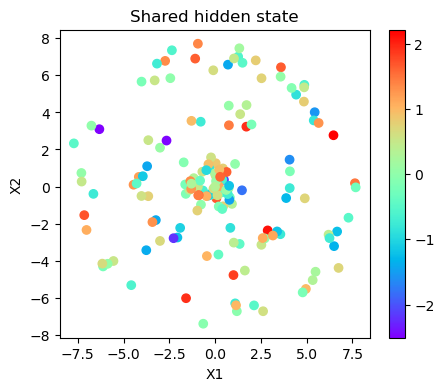

In [13]:
print(model.hidden_state.shape)
x1 = x_train.detach().numpy()[:, 0]
x2 = x_train.detach().numpy()[:, 1]
c = model.hidden_state.detach().numpy().squeeze()
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(x1, x2, c=c, cmap='rainbow')
ax.set_title('Shared hidden state')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
cbar = plt.colorbar(ax.collections[0], ax=ax)
plt.show()

In [105]:
def predict_confounder(x_test):
    # Run the model with the test data
    with torch.no_grad():
        # Use the trained guide to sample the posterior of z given x_test
        sampled_z = mean_field_guide()
        
    return sampled_z

# Example usage with x_test
z_pred = predict_confounder(x_test)

In [106]:
for name in z_pred:
    print(name, z_pred[name].shape)

model1.GP.layers.0.layers.0.layer.weight torch.Size([10, 1])
model1.GP.layers.0.layers.1.layer.weight torch.Size([2, 20])
model2.GP.layers.0.layers.0.layer.weight torch.Size([10, 3])
model2.GP.layers.0.layers.1.layer.weight torch.Size([6, 20])
sigma1 torch.Size([])
sigma2 torch.Size([])


In [67]:
x1 = x_test.detach().numpy()[:, 0]
x2 = x_test.detach().numpy()[:, 1]
c = z_pred.detach().numpy().squeeze()
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(x1, x2, c=c, cmap='rainbow')
ax.set_title('Shared hidden state')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
cbar = plt.colorbar(ax.collections[0], ax=ax)
plt.show()

AttributeError: 'dict' object has no attribute 'detach'

In [14]:
predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(x_train)
y_pred = preds['obs2'].cpu().detach().numpy().mean(axis=0)
y1_labels = np.argmax(y_pred[:,0:3], axis=1)
y2_labels = np.argmax(y_pred[:,3:6], axis=1)

# Calculate accuracy for task 1 on train dataset
accuracy_y1_train = np.mean(y1_labels == np.array(np.argmax(y_train[:, 0:3], axis=1)))
print(f"Accuracy for task 1 on train dataset: {accuracy_y1_train * 100:.2f}%")

# Calculate accuracy for task 2 on train dataset
accuracy_y2_train = np.mean(y2_labels == np.array(np.argmax(y_train[:, 3:6], axis=1)))
print(f"Accuracy for task 2 on train dataset: {accuracy_y2_train * 100:.2f}%")

Accuracy for task 1 on train dataset: 100.00%
Accuracy for task 2 on train dataset: 97.50%


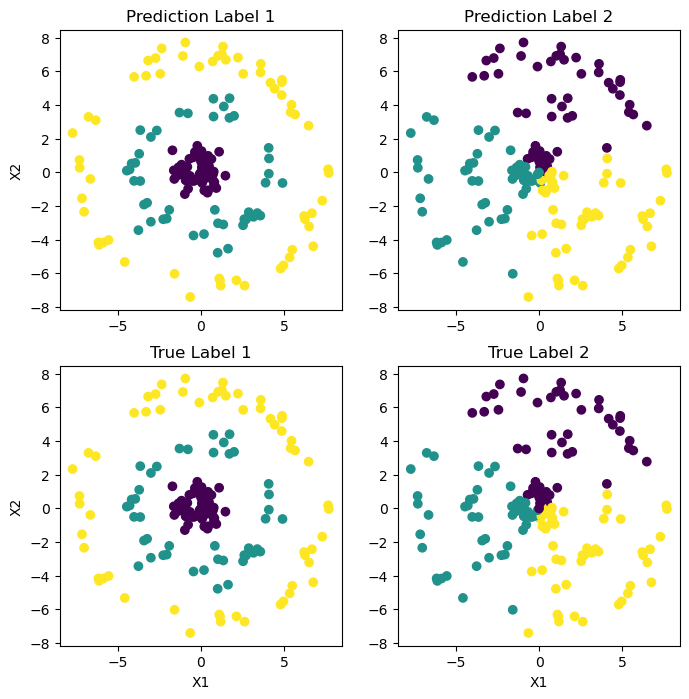

In [15]:
fig, ax = plt.subplots(2,2, figsize=(8, 8))
ax[0,0].scatter(x_train[:,0], x_train[:,1], c=y1_labels)
ax[0,1].scatter(x_train[:,0], x_train[:,1], c=y2_labels)
ax[1,0].scatter(x_train[:,0], x_train[:,1], c=np.argmax(y_train[:,0:3], axis=1))
ax[1,1].scatter(x_train[:,0], x_train[:,1], c=np.argmax(y_train[:,3:6], axis=1))
ax[0,0].set_title('Prediction Label 1')
ax[0,1].set_title('Prediction Label 2')
ax[1,0].set_title('True Label 1')
ax[1,1].set_title('True Label 2')
ax[1,0].set_xlabel('X1')
ax[1,1].set_xlabel('X1')
ax[0,0].set_ylabel('X2')
ax[1,0].set_ylabel('X2')
plt.show()

In [16]:
predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(x_test)
y_pred = preds['obs'].cpu().detach().numpy().mean(axis=0)
y1_labels1 = np.argmax(y_pred[:,0:3], axis=1)
y2_labels1 = np.argmax(y_pred[:,3:6], axis=1)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 160 but got size 40 for tensor number 1 in the list.
                                Trace Shapes:        
                                 Param Sites:        
                                Sample Sites:        
model1.GP.layers.0.layers.0.layer.weight dist | 10  1
                                        value | 10  1
model1.GP.layers.0.layers.1.layer.weight dist |  2 20
                                        value |  2 20